In [1]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# %cd drive/MyDrive/datasets/

In [2]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [3]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

# df = df.append(df_test, ignore_index=True)

In [4]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#"))]
    return len(newlist)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

def clean_text(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith((":", "@", "#"))]
    return ' '.join(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not re.match(r'([\:\;\=][\(\)PD]+)+', x)]
    return len(newlist)

def exclamation_mark_counter(s):
    return s.count('!')

In [5]:
df['length'] = df['Tweet text'].apply(len)
df['word_count'] = df['Tweet text'].apply(word_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['exclamation_mark_count'] = df['Tweet text'].apply(exclamation_mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)
df['clean_text'] = df['Tweet text'].apply(clean_text)

In [6]:
nlp = spacy.load("en_core_web_md") # treba instalirat ako nemate, s md cemo dobivat bolji performans a i dalje nije prevelik

In [9]:
# ###lista svih listi tokena

# all_tokens_list = []
# for index, row in df.iterrows():
#     token_list = []
#     doc = nlp(row['clean_text'])
#     for token in doc:
#         token_list.append(token)
#     all_tokens_list.append(token_list)

In [7]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [8]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
1500,1501,0,"@bayer04fussball draw, @s04 draw, @Everton goi...",122,18,3,0,0,21,0,0,"draw, draw, going to lose, Pelle on my bench i..."
1880,1884,0,Just gave Imperfecto a 3.5/5 rating on @Zomato...,70,8,1,0,1,9,0,0,Just gave Imperfecto a 3.5/5 rating on http://...
2941,2945,0,I need to do something legendary this winter b...,51,9,0,0,0,9,0,0,I need to do something legendary this winter b...
1077,1078,1,I am starting to think UK has a pretty good ba...,66,12,0,1,0,13,0,0,I am starting to think UK has a pretty good ba...
1774,1778,0,@aleciamarie21 @DonnieWahlberg is it bad that ...,180,17,2,0,0,19,1,2,"is it bad that after my ""happy Preds won"" danc..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3353,3368,1,A strange day so far everyone seems in such a ...,130,24,0,0,0,24,0,0,A strange day so far everyone seems in such a ...
1687,1691,1,First day skiing #killedit #iwasshit #tignes ...,81,4,0,4,1,8,0,0,First day skiing http://t.co/oHYSozoNPP
2990,2994,0,@KeirSimmons another Bush in the Whitehouse.\r,46,5,1,0,0,6,0,0,another Bush in the Whitehouse.
2659,2663,0,All I wanted was to see you\r,28,7,0,0,0,7,0,0,All I wanted was to see you


## Topic Modeling

In [11]:
tweet_text_train = df_train[['Tweet text']]
tweet_text_validation = df_validation[['Tweet text']]

tweet_text_train.head(15)

,Tweet text
1135,@MarcotteJN @KillerKalen yeah I'm avoiding you...
3312,@Wields Ill see you in the Finals
285,"Thanks @AirAsia, for nothing. All my family we..."
2876,@sommelierkeith hope you had a nice Xmas babes X
2824,@FunnyIines: DONT SAY ANYTHING JUST RT https:/...
1835,Lol at people saying they're turning 13 this y...
2428,I love that my body can't handle school stress...
199,Church sign of the day: How would you feel if ...
3365,@hollis51 gerrymandering neither party will gi...
2336,@GG_Studio:Congratulations GG for giving us am...


In [12]:
def preprocess_words(s):
    '''Removes tags, emojis, links, smiley faces, hashtag signs, stopwords and changes the case to lower.'''
    ret_list = []

    is_tag = lambda w: w.startswith('@')
    is_emoji = lambda w: w != ":" and w.startswith(":") and w.endswith(":")
    is_link = lambda w: w.startswith("http:") or w.startswith("https:")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(r'([\:\;\=][\(\)PD]+)+', w)
    is_not_stopword = lambda w: w not in nlp.Defaults.stop_words
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w):
                pass
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    w2.append(w_tmp.lower())
            
            elif is_smiley(w):
                w_tmp = re.sub(r'([\:\;\=][\(\)PD]+)+', '', w)
                if w_tmp != '':
                    w2.append(w_tmp.lower())
            
            elif is_not_stopword(w):
                w2.append(w.lower())
            
        ret_list.append(' '.join(w2))
    return ret_list

tweet_text_train = tweet_text_train.apply(preprocess_words)
tweet_text_validation = tweet_text_validation.apply(preprocess_words)

In [13]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences'''
    return [[w.lemma_ for w in nlp(s_i)] for s_i in s]

def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return [' '.join([w for w in s_i]) for s_i in s]

tweet_text_train = tweet_text_train.apply(lemmatize)
tweet_text_validation = tweet_text_validation.apply(lemmatize)

In [14]:
tweet_text_train = join_docs(tweet_text_train['Tweet text'])
tweet_text_validation = join_docs(tweet_text_validation['Tweet text'])

In [15]:
def gensim_preprocess(s):
    '''Uses gensims preprocess function to prepare the data for topic modeling'''
    return [' '.join(simple_preprocess(s_i, deacc=True)) for s_i in s]

tweet_text_train = gensim_preprocess(tweet_text_train)
tweet_text_validation = gensim_preprocess(tweet_text_validation)

In [16]:
display(tweet_text_train[1401])
display(tweet_text_train[1416])
display(tweet_text_train[1428])

'playstation everything be awesome'

'ah soul make sunday morning work bearable cold happy'

'online shopping credit card umm justbrowse'

In [17]:
def get_likelihoods_and_perplexities(train, validation, model_range, batch_size=64):
    '''
    Returns a list of train and validation log likelihoods and perplexities for LDA models
    in the given range using the given vectorizer
    '''
    models, logl_train, logl_val, perp_train, perp_val = [], [], [], [], []
    for i in model_range:
        lda = LatentDirichletAllocation(
            n_components=i,
            max_iter=10,
            learning_method='online',
            batch_size=batch_size,
            evaluate_every = -1,
            n_jobs = -1,
        )
        
        lda.fit(train)
        
        logl_train.append(lda.score(train))
        logl_val.append(lda.score(validation))
        perp_train.append(lda.perplexity(train))
        perp_val.append(lda.perplexity(validation))
        models.append(lda)
                         
    return models, logl_train, logl_val, perp_train, perp_val
                        
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=0.1,
    max_df=0.6,
)

vectorizer2 = TfidfVectorizer(
    analyzer='word',
    min_df=0.1,
    max_df=0.6,
)

tweet_text_count_train = vectorizer.fit_transform(tweet_text_train)
tweet_text_count_validation = vectorizer.transform(tweet_text_validation)

tweet_text_tfidf_train = vectorizer2.fit_transform(tweet_text_train)
tweet_text_tfidf_validation = vectorizer2.transform(tweet_text_validation)

In [18]:
# models, logl_train, logl_val, perp_train, perp_val = get_likelihoods_and_perplexities(tweet_text_count_train, \
#                                                             tweet_text_count_validation, range(2, 50))

In [19]:
# model_range = list(range(2, 50))

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].plot(model_range, logl_train, 'o-')
# axs[0].plot(model_range, logl_val, 'o-')

# axs[1].plot(model_range, perp_train, 'o-')
# axs[1].plot(model_range, perp_val, 'o-')


In [20]:
# from tmtoolkit.topicmod import tm_lda
# from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
# from tmtoolkit.topicmod.evaluate import results_by_parameter
# from tmtoolkit.topicmod.visualize import plot_eval_results


# const_params = {
#     'n_iter': 10,
#     'eta':0.01,
# }

# # https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Evaluation-of-topic-models
# # https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/

# # alpha    - for a prior over the document-specific topic distributions
# #          - important for sparsity (low value means less impact - document contains a mixture of only few topics)
# # eta/beta - for a prior over the topic-specific word distributions
# #          - high beta value means a lower impact of word sparsity - each topic will contain most of the words of the corpus
# #          - low beta value means the topics should be more specific, i.e. their word probabilities will be less uniform,
# # low beta + low alpha

# var_params = [
#     {'n_topics': k, 'alpha': 1/k}
#     for k in range(5, 101, 100)
# ]


# eval_results = evaluate_topic_models(
#     tweet_text_count_train,
#     varying_parameters=var_params,
#     constant_parameters=const_params,
#     coherence_mimno_2011_top_n=10,
#     coherence_mimno_2011_include_prob=True,
#     return_models=True
#     n_max_proces=-1
# )

# eval_results[:3]  # only show first three models

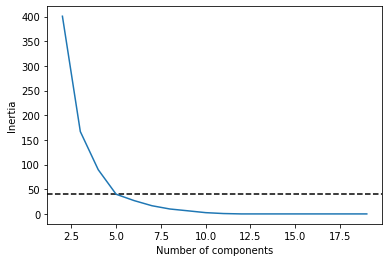

In [40]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
plt.axhline(inertia[3], c='k',  linestyle='dashed')
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

## Embedding

In [9]:
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe

In [10]:
tweet_embedding_train = df_train[['clean_text', 'Label']]
tweet_embedding_validation = df_validation[['clean_text', 'Label']]

In [11]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)

In [12]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=2)

TWEET = Field('clean_text', pretokenize_hooks=[str.lower], numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(tweet_embedding_train, fields)
validation = TabularDataset.from_pandas(tweet_embedding_validation, fields)
train.finalize_fields()

glove = GloVe()
# Load only the vectors of vocab words.
embeddings = glove.load_vocab(vocab)

# Generate padded batch.
train_batch = train.batch(add_padding=True)
test_batch = validation.batch(add_padding=True)

In [13]:
train_batch['clean_text'].astype(int)

array([[1353, 1353,   74, ...,    1,    1,    1],
       [  19,  753,    0, ...,    1,    1,    1],
       [   5,   87,    3, ...,    1,    1,    1],
       ...,
       [ 160,  995,    8, ...,    1,    1,    1],
       [  27,    5,  357, ...,    1,    1,    1],
       [ 120,  622,  748, ...,    1,    1,    1]])

In [14]:
tweet_train = embeddings[train_batch['clean_text'].astype(int)]
tweet_test = embeddings[test_batch['clean_text'].astype(int)]
# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)
# Median
tweet_train_median = np.median(tweet_train, axis=1)
tweet_test_median = np.median(tweet_test, axis=1)
# Variance
tweet_train_std = tweet_train.std(axis=1)
tweet_test_std = tweet_test.std(axis=1)

In [15]:
embaddings_train_mean_df = pd.DataFrame(tweet_train_mean)
tweet_embedding_train = pd.merge(tweet_embedding_train, embaddings_train_mean_df, left_index=True, right_index=True)

embaddings_test_mean_df = pd.DataFrame(tweet_test_mean)
tweet_embedding_test = pd.merge(tweet_embedding_validation, embaddings_test_mean_df, left_index=True, right_index=True)

In [16]:
tweet_embedding_test

,clean_text,Label,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,Sweet United Nations video. Just in time for C...,1,-0.143208,0.125154,0.617673,0.710176,-0.931200,-0.901535,-0.709320,0.265951,...,0.656036,0.837494,-1.119785,0.375256,-0.253029,1.178032,0.001807,0.404764,-0.243681,0.326935
1,3 episodes left I'm dying over here,0,-0.132109,0.101051,0.749344,0.727423,-0.973546,-0.946062,-0.835888,0.298951,...,0.689564,0.847522,-1.158082,0.512170,-0.178429,1.216739,0.079070,0.441368,-0.228380,0.306440
2,Nothing makes me happier then getting on the h...,1,-0.122154,0.070073,0.513791,0.527171,-0.775217,-0.709135,-0.621702,0.226396,...,0.559840,0.650367,-0.941178,0.324850,-0.207901,0.907649,0.022707,0.314525,-0.178422,0.297150
3,4:30 an opening my first beer now gonna be a l...,0,-0.169523,0.117616,0.587327,0.660195,-0.880731,-0.845741,-0.726717,0.274057,...,0.659972,0.782035,-1.056482,0.391901,-0.227005,1.059128,0.049982,0.380057,-0.245896,0.325211
4,do you think you would support a guy who knock...,0,-0.180550,0.114283,0.489894,0.598455,-0.763975,-0.775944,-0.608282,0.252754,...,0.634504,0.651863,-0.987943,0.291869,-0.229595,0.916654,-0.039780,0.316389,-0.216749,0.278653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,"Unless rogue theatres start showing it, or it ...",0,-0.152671,0.135360,0.587685,0.693809,-0.906025,-0.898615,-0.687654,0.303219,...,0.675820,0.820589,-1.112471,0.375695,-0.322194,1.092719,-0.045435,0.389843,-0.254811,0.315552
1141,I'm glad the DC Council has it's priorities in...,1,-0.127197,0.121340,0.678638,0.691767,-0.968154,-0.931384,-0.749007,0.295726,...,0.677301,0.829772,-1.121108,0.452483,-0.217650,1.173995,0.048142,0.410433,-0.189058,0.312962
1142,Chill http://t.co/SnUkkgCDB9,0,-0.144225,0.095510,0.783521,0.814883,-1.044772,-1.021176,-0.898538,0.336206,...,0.792969,0.955631,-1.279963,0.511473,-0.267325,1.302332,0.041872,0.511403,-0.268921,0.347724
1143,Another one of our support vehicles modified f...,0,-0.184849,0.117919,0.609249,0.656996,-0.906237,-0.905896,-0.691985,0.266045,...,0.664565,0.803829,-1.100600,0.348804,-0.282677,1.146920,-0.045521,0.395182,-0.267424,0.301131


In [17]:
from sklearn.linear_model import LogisticRegression
X_ = tweet_embedding_train[[x for x in range(300)]]
y_ = tweet_embedding_train['Label']
clf = LogisticRegression(random_state=1, solver='liblinear', C=10).fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_test = tweet_embedding_test[[x for x in range(300)]]
y_test = tweet_embedding_test['Label']
print(clf.score(X_test, y_test))

Train score
0.6324850299401198
Validation score
0.6183406113537118


In [ ]:
## Features
## Broj neg rijeci
## Broj poz rijeci
## Omjer
## Udaljenost izmedu poz i neg rijeci

Potrebno dodatno preprocesat da samo rjeci ostanu

In [75]:
import nltk
## nltk.download('vader_lexicon') if error run this
from nltk.sentiment import SentimentIntensityAnalyzer
import copy

def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['clean_text']) > 0:
            doc = nlp(row['clean_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(copy.copy(current_neg))
            neg_word_count.append(copy.copy(len(current_neg)))
            pos_words.append(copy.copy(current_pos))
            pos_word_count.append(copy.copy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [72]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
0,1501,0,"@bayer04fussball draw, @s04 draw, @Everton goi...",122,18,3,0,0,21,0,0,"draw, draw, going to lose, Pelle on my bench i..."
1,1884,0,Just gave Imperfecto a 3.5/5 rating on @Zomato...,70,8,1,0,1,9,0,0,Just gave Imperfecto a 3.5/5 rating on http://...
2,2945,0,I need to do something legendary this winter b...,51,9,0,0,0,9,0,0,I need to do something legendary this winter b...
3,1078,1,I am starting to think UK has a pretty good ba...,66,12,0,1,0,13,0,0,I am starting to think UK has a pretty good ba...
4,1778,0,@aleciamarie21 @DonnieWahlberg is it bad that ...,180,17,2,0,0,19,1,2,"is it bad that after my ""happy Preds won"" danc..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2667,3368,1,A strange day so far everyone seems in such a ...,130,24,0,0,0,24,0,0,A strange day so far everyone seems in such a ...
2668,1691,1,First day skiing #killedit #iwasshit #tignes ...,81,4,0,4,1,8,0,0,First day skiing http://t.co/oHYSozoNPP
2669,2994,0,@KeirSimmons another Bush in the Whitehouse.\r,46,5,1,0,0,6,0,0,another Bush in the Whitehouse.
2670,2663,0,All I wanted was to see you\r,28,7,0,0,0,7,0,0,All I wanted was to see you


In [85]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)

In [86]:
df_train['neg_word_count'] = neg_word_count_train
df_train['neg_word'] = neg_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['pos_word'] = pos_words_train
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word
0,1501,0,"@bayer04fussball draw, @s04 draw, @Everton goi...",122,18,3,0,0,21,0,0,"draw, draw, going to lose, Pelle on my bench i...",2,"[lose, shit]",0,[]
1,1884,0,Just gave Imperfecto a 3.5/5 rating on @Zomato...,70,8,1,0,1,9,0,0,Just gave Imperfecto a 3.5/5 rating on http://...,0,[],0,[]
2,2945,0,I need to do something legendary this winter b...,51,9,0,0,0,9,0,0,I need to do something legendary this winter b...,0,[],0,[]
3,1078,1,I am starting to think UK has a pretty good ba...,66,12,0,1,0,13,0,0,I am starting to think UK has a pretty good ba...,0,[],2,"[pretty, good]"
4,1778,0,@aleciamarie21 @DonnieWahlberg is it bad that ...,180,17,2,0,0,19,1,2,"is it bad that after my ""happy Preds won"" danc...",1,[bad],2,"[happy, win]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,3368,1,A strange day so far everyone seems in such a ...,130,24,0,0,0,24,0,0,A strange day so far everyone seems in such a ...,2,"[strange, drunk]",1,[good]
2668,1691,1,First day skiing #killedit #iwasshit #tignes ...,81,4,0,4,1,8,0,0,First day skiing http://t.co/oHYSozoNPP,0,[],0,[]
2669,2994,0,@KeirSimmons another Bush in the Whitehouse.\r,46,5,1,0,0,6,0,0,another Bush in the Whitehouse.,0,[],0,[]
2670,2663,0,All I wanted was to see you\r,28,7,0,0,0,7,0,0,All I wanted was to see you,0,[],0,[]


In [87]:
df_validation['neg_word_count'] = neg_word_count_val
df_validation['neg_word'] = neg_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['pos_word'] = pos_words_val

In [93]:
from sklearn.linear_model import LogisticRegression
X_ = df_train[['neg_word_count', 'pos_word_count']]
y_ = df_train['Label']
clf = LogisticRegression(random_state=0).fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[['neg_word_count', 'pos_word_count']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.6014221556886228
Validation score
0.5816593886462882


In [97]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        Weather bomb. Weather. Bomb. ||I applaud the m...
pos_word                                [applaud, innovation, help]
pos_word_count                                                    3
neg_word                                               [bomb, bomb]
neg_word_count                                                    2
Name: 25, dtype: object

In [121]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(copy.copy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [126]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)

In [127]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word,pos_neg_within_4,pos_neg_within_5
0,1501,0,"@bayer04fussball draw, @s04 draw, @Everton goi...",122,18,3,0,0,21,0,0,"draw, draw, going to lose, Pelle on my bench i...",2,"[lose, shit]",0,[],0,0
1,1884,0,Just gave Imperfecto a 3.5/5 rating on @Zomato...,70,8,1,0,1,9,0,0,Just gave Imperfecto a 3.5/5 rating on http://...,0,[],0,[],0,0
2,2945,0,I need to do something legendary this winter b...,51,9,0,0,0,9,0,0,I need to do something legendary this winter b...,0,[],0,[],0,0
3,1078,1,I am starting to think UK has a pretty good ba...,66,12,0,1,0,13,0,0,I am starting to think UK has a pretty good ba...,0,[],2,"[pretty, good]",0,0
4,1778,0,@aleciamarie21 @DonnieWahlberg is it bad that ...,180,17,2,0,0,19,1,2,"is it bad that after my ""happy Preds won"" danc...",1,[bad],2,"[happy, win]",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,3368,1,A strange day so far everyone seems in such a ...,130,24,0,0,0,24,0,0,A strange day so far everyone seems in such a ...,2,"[strange, drunk]",1,[good],0,0
2668,1691,1,First day skiing #killedit #iwasshit #tignes ...,81,4,0,4,1,8,0,0,First day skiing http://t.co/oHYSozoNPP,0,[],0,[],0,0
2669,2994,0,@KeirSimmons another Bush in the Whitehouse.\r,46,5,1,0,0,6,0,0,another Bush in the Whitehouse.,0,[],0,[],0,0
2670,2663,0,All I wanted was to see you\r,28,7,0,0,0,7,0,0,All I wanted was to see you,0,[],0,[],0,0


In [133]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']
clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.5086077844311377
Validation score
0.4733624454148472


In [ ]:
within_5_val